&nbsp;

# 6. Final Pipeline 
A pipeline is a means of automating the machine learning workflow. What this means is that we can process and transform our data in a sequence of steps making the process of ingesting data, transforming it, and conducting predictions seamless. Also the pipeline itself can be used as an estimator, whether it's fitting data to it or making predictions. Another benefit of using pipelines aside from the obvious efficiency is that it automatically prevents data leakage from occurring (where our model learns something from the data).  

In [1]:
# Standard libraries. 
import pandas as pd
import numpy as np 
import os
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Importing our functions. 
import functions
import visuals

# Importing emsemble models. 
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

# Import transformers. 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Import pickle library. 
from pickle import load

# Renders plotly figs into svg static images. 
import plotly.io as pio
pio.renderers.default = "svg"

In [2]:
root = os.getcwd() # Setting root directory as cwd. 
trainData = pd.read_csv(r"{}\train_PriceCapRemoved.csv".format(root)) # Importing the train set.
holdoutSet = pd.read_csv(r"{}\test.csv".format(root)) # Importing the test set we kept aside.
holdoutSet = holdoutSet[holdoutSet["MEDV"] !=50] # Removing price cap. 
holdoutSet.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.03738,0.0,5.19,0,0.515,6.310,38.5,6.4584,5,224.0,20.2,389.4,6.75,20.7
1,13.35980,0.0,18.10,0,0.693,5.887,94.7,1.7821,24,666.0,20.2,396.9,16.35,12.7


&nbsp;

### Section A: Evaluating on the Holdout Set
In this section we're finally going to evlauate model perfrormance on the holdout set that we have separated from our train data. Based on the results, we will pick the best performing model to use as our finalised pipeline. 

**A.1: MSE on the Holdoutset**<br>
First we'll create our pipeline with all of our transformers, train the estimator on our entire train dataset then use our estimator to predict our holdout set's labels. We will do this over 30 iterations and store all results inside an empty list to later visualise.

In [3]:
# Splitting features and label.
holdoutX = holdoutSet.iloc[:,:-1]
holdoutLabels = holdoutSet.iloc[:,-1]

# Storing MSE scores over 30 iterations.
scoresGBR, scoresRFR, scoresXGB = list(), list(), list()

In [4]:
GBR = functions.model_evaluation()
GBR.preprocessing(trainData)
GBR.add_pipe_component("clf", GradientBoostingRegressor(learning_rate=0.1, max_depth=20, min_samples_split=50, n_estimators=500,
                                                        validation_fraction=0.2, n_iter_no_change=8, tol=1.5))
GBR.holdout_set_evaluation(y_axis=scoresGBR, train_data=trainData, holdout_features=holdoutX, holdout_labels=holdoutLabels)

In [5]:
RFR = functions.model_evaluation()
RFR.preprocessing(trainData)
RFR.add_pipe_component("log", FunctionTransformer(np.log1p))
RFR.add_pipe_component("clf", RandomForestRegressor(max_depth=20, min_samples_split=18, min_samples_leaf=2, n_estimators=500))
RFR.holdout_set_evaluation(y_axis=scoresRFR, train_data=trainData, holdout_features=holdoutX, holdout_labels=holdoutLabels)

In [6]:
XGB = functions.model_evaluation()
XGB.preprocessing(trainData)
XGB.add_pipe_component("log", FunctionTransformer(np.log1p))
XGB.add_pipe_component("clf", XGBRegressor(learning_rate=0.1, max_depth=2, min_child_weight=15, n_estimators=101))
XGB.holdout_set_evaluation(y_axis=scoresXGB, train_data=trainData, holdout_features=holdoutX, holdout_labels=holdoutLabels)

**A.2: Plotting the MSE Scores**<br> 
We will recursively predict the MSE over 30 iterations and store the results inside an empty list. The objective is to see if there is any variance across all iterations, and to find the average scores to determine which model performed the best. We should also consider if any model shows too much volatility in their MSE, then it might be better to choose the model with more consistent results.

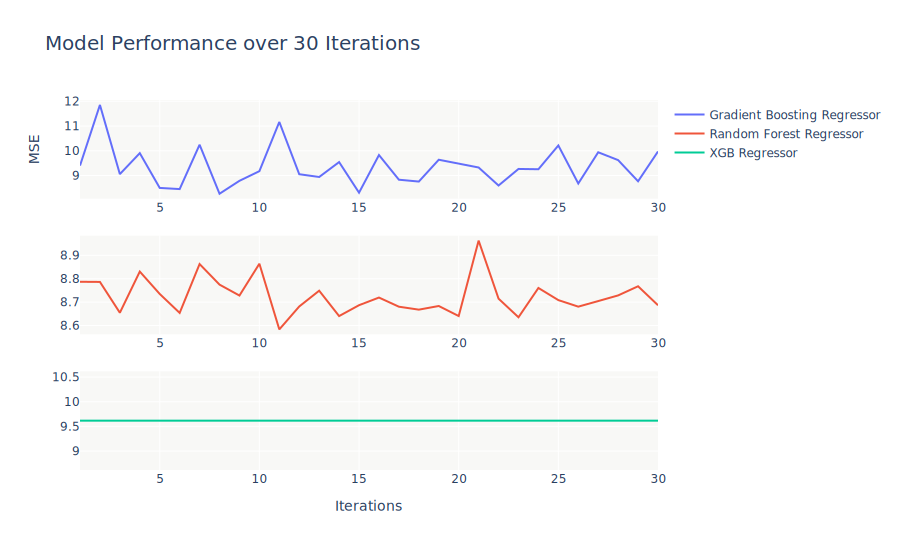

In [7]:
visuals.MSE_plot(scoresGBR, scoresRFR, scoresXGB, "MSE")

In [8]:
print("The average MSE over 30 iterations for Gradient Boosting Regressor is: %.4f" % (np.mean(scoresGBR)))
print("The average MSE over 30 iterations for Random Forest Regressor is: %.4f" % (np.mean(scoresRFR)))
print("The average MSE over 30 iterations for XGB Regressor is: %.4f" % (np.mean(scoresXGB)))

The average MSE over 30 iterations for Gradient Boosting Regressor is: 9.3615
The average MSE over 30 iterations for Random Forest Regressor is: 8.7254
The average MSE over 30 iterations for XGB Regressor is: 9.6166


**A.3: Plotting the RMSE**<br> 
The RMSE is just the MSE square rooted, so the plot should be exactly the same shape/variance as the MSE plot jsut at different scale.

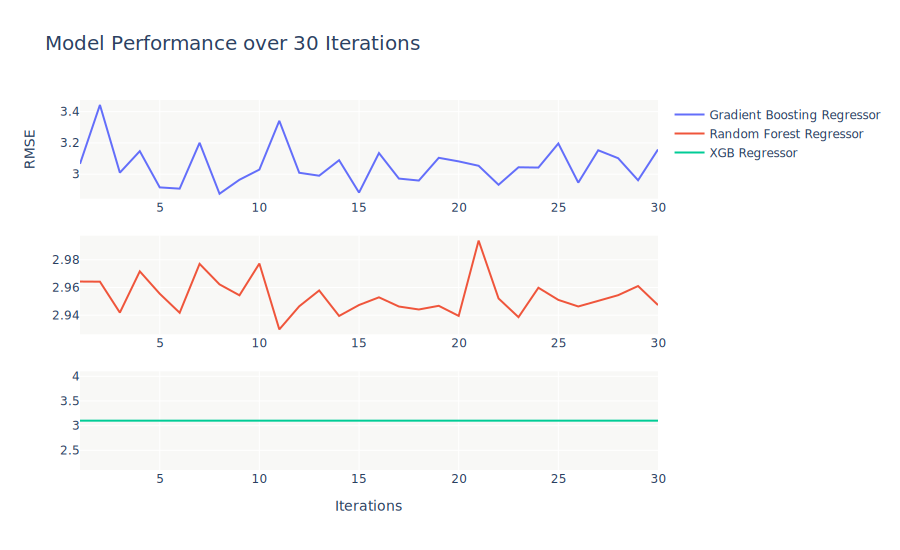

In [9]:
# Using the same MSE plot function, we just need to apply a square root function to our results. 
visuals.MSE_plot(np.sqrt(scoresGBR), np.sqrt(scoresRFR), np.sqrt(scoresXGB), "RMSE")

In [10]:
print("The average RMSE over 30 iterations for Gradient Boosting Regressor is: %.4f" % (np.sqrt(np.mean(scoresGBR))))
print("The average RMSE over 30 iterations for Random Forest Regressor is: %.4f" % (np.sqrt(np.mean(scoresRFR))))
print("The average RMSE over 30 iterations for XGB Regressor is: %.4f" % (np.sqrt(np.mean(scoresXGB))))

The average RMSE over 30 iterations for Gradient Boosting Regressor is: 3.0597
The average RMSE over 30 iterations for Random Forest Regressor is: 2.9539
The average RMSE over 30 iterations for XGB Regressor is: 3.1011


* Both our Gradient Boosting and Random Forest Regressors seem to fluctuate over the 30 iterations while the XGB Regressor predicted consistently over time.
* Based on the results, our chosen final model will be the Random Forest Regressor due to its great performance. 

| Model | Model Type | MSE | RMSE | 
|---------|---------|---------|---------|
| **Gradient Boosting Regressor** | Base Model   |9.32 | 3.05 |
| **Random Forest Regressor** | Log Transformed |8.75 |2.96 |
| **XGB Regressor** | Log Transformed | 9.69 |3.11 |

&nbsp;

### Section B: Saving & Loading Models
In this section we're going to export our best performing model into our current working directory, then load the model back in and make the same predictions again to see if everything saved correctly. 

**B.1: Saving and Exporting our Model as a Pickle File**<br>
Now it's time to save our pipeline estimator and export it as a pkl file into our current working directory.

In [11]:
# Saving our finalised model and exporting it in our cwd as a pickle file. 
functions.saving_model(train_data=trainData, model=RandomForestRegressor(max_depth=20, min_samples_split=18, min_samples_leaf=2,
                                                                         n_estimators=500))

**B.2: Loading our pickle File and Evaluation**<br>
The next part is to load our model back into the script and evaluate it again on the holdoutset. We run this again just to make sure that our entire pipeline components saved and loaded correctly and that our model has still retained its high performance.

In [12]:
# Loading our model back in. 
loaded_model = load(open("RandomForestRegressor.pkl", "rb"))

**B.3: Predicting on the Holdoutset**<br>
Now it's time to test the performance of our loaded model.

In [13]:
# Predicting probabilities on the Holdout set's features. 
yhat = loaded_model.predict(holdoutX)

# Error metrics. 
MSE = abs(mean_squared_error(holdoutLabels, yhat))
RMSE = np.sqrt(abs(mean_squared_error(holdoutLabels, yhat)))

print(f"Our Random Forest Regressor scored an MSE of: %.4f and a RMSE of: %.4f on the holdout set." % (MSE, RMSE))

Our Random Forest Regressor scored an MSE of: 8.6769 and a RMSE of: 2.9457 on the holdout set.


* It looks like our loaded model performed exactly how we wanted it to.

&nbsp;

### Section C: Residual Plot
A residual plot shows the difference between the observed response and the fitted response values. In a perfect scenario we would want all our points clustered around zero because it would mean our model can make predictions with little to no error. 

**C.1: Plotting the Residual Plot**<br>
Before we can plot our residual plot we first need to calculate our residuals, which is a simple formula of (actuals - predicted).

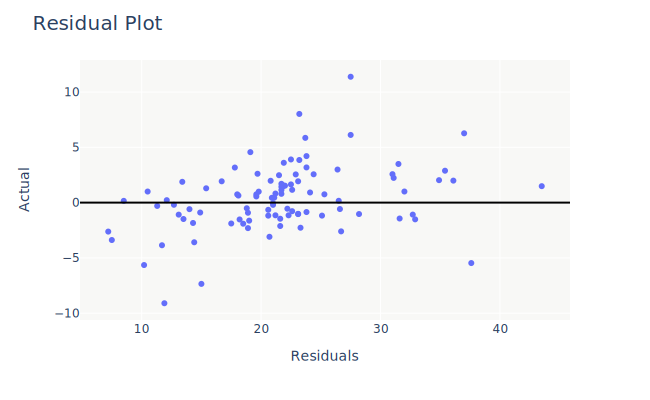

In [14]:
# Calculating residuals. 
residuals = holdoutLabels - yhat

visuals.residual_plot(xaxis=holdoutLabels, yaxis=residuals)

* Generally we want most of our points to be as close to the zero line as possible. So far the majority of our points are clustered around the line, with a few points drifting at the 10 points apart.
* Another way to check if our points are close to the line is by plotting the distribution.

**C.2: Distribution of Errors**<br>
The next step is to check the distribution of our residuals.

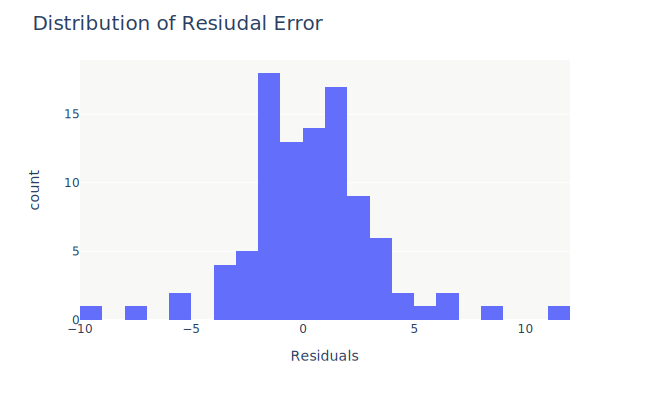

In [15]:
visuals.distribution(xaxis=residuals)

* As you can see our residuals show a normal distribution which means most of the data is concerntrated around the mean of 0, which is exactly what we want.

**C.3: R2**<br>
R2 is a goodness-of-fit measure for regression models. This statistic indicates the % of the variance in the dependant variable that the independant variables explain collectively. It is measured on a scale from 0-100%.

In [16]:
r2 = r2_score(holdoutLabels, yhat)

print("An R2 of %.2f%% tells us that %.2f%% of the variability observed in the target variable is explained by our model." % (r2*100, r2*100))

An R2 of 81.41% tells us that 81.41% of the variability observed in the target variable is explained by our model.


**C.4: Mean Absolute Error**<br>
The MAE is basically on average the errors our algorithm will make when conducting predictions. It's always good to calculate the MAE as unlike MSE, the MAE is in the same scale as the dataset, so it's easier to make comparisons when using mean absolute error. 

In [17]:
mae = abs(mean_absolute_error(holdoutLabels, yhat)) # Calculating mean absloute error. 

# Importing the full data. 
fullDF = pd.read_csv(r"{}\boston_housing.csv".format(root), delim_whitespace=True, header=None) # Importing the entire dataset.
bostonHeaders = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
fullDF.columns = bostonHeaders # Defining our headers.
meanMEDV = fullDF["MEDV"].mean() # Average value of MEDV.

print("The mean absolute score of our XGB Regressor is: %.2f and the mean of our target variable is: %.2f" % (mae, meanMEDV))

The mean absolute score of our XGB Regressor is: 2.17 and the mean of our target variable is: 22.53


**C.5: Conclusion**<br>
Through our empirical testing on the holdout set, the model that performed the best was our Random Forest Regressor which scored an MSE of 8.75, a RMSE of 2.96 and a R2 score of 81.31%. Furthermore when plotting the distribution of our residuals, our regressor showed a symmetrical distriubtion with a mean of 0, which indicates when conducting predictions our regressor is less likely to make errors. 

The mean value of "MEDV" (label) is 22.53, while our "Mean Absolute Error" is 2.17. This tells us on average our predictions are off by 2.17, and that we have a 9.64% error rate (2.17/23.53).

&nbsp;

| Model | Model Type | MSE | RMSE | R2 |  Hyperparameters | 
|---------|---------|---------|---------|---------|---------|
| **Gradient Boosting Regressor** | Base Model   |9.32 | 3.05 | - |learning_rate=0.1, max_depth=20, min_samples_split=50, n_estimators=500, <br>validation_fraction=0.2, n_iter_no_change=8, tol=1.5 |
| **Random Forest Regressor** | Log Transformed |8.75 |2.96 | 81.31% |max_depth=20, min_samples_split=18, min_samples_leaf=2,  n_estimators=500|
| **XGB Regressor** | Log Transformed | 9.69 |3.11 | -|learning_rate=0.1, max_depth=2, min_child_weight=15, n_estimators=101|

&nbsp;

&nbsp;
**Author:** Aaron Chew&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Date Published:** 11/08/2022 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Email:** aaronsamuelchew@gmail.com &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **GitHub:** https://github.com/aaron-chew  